In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [185]:
from glob import glob
import librosa as lr
from librosa.core import stft, amplitude_to_db
from librosa.display import specshow
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Heartbeat Sounds Dataset

In [3]:
# convenience plotting function
def show_plot_and_make_titles():
    axs[0, 0].set(title='Normal Heartbeats')
    axs[0, 1].set(title='Abnormal Heartbeats')
    plt.tight_layout()

In [115]:
# load data
normal = pd.read_csv('./normal_sound.csv', index_col=0)
abnormal = pd.read_csv('./abnormal_sound.csv', index_col=0)
sfreq = 2205
print(normal.shape)
print(abnormal.shape)

(8820, 3)
(8820, 3)


In [15]:
normal.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8820 entries, 0.0 to 3.9995464852607716
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3       8820 non-null   float64
 1   4       8820 non-null   float64
 2   6       8820 non-null   float64
dtypes: float64(3)
memory usage: 275.6 KB


In [16]:
abnormal.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8820 entries, 0.0 to 3.9995464852607716
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8820 non-null   float64
 1   1       8820 non-null   float64
 2   2       8820 non-null   float64
dtypes: float64(3)
memory usage: 275.6 KB


In [17]:
normal.head()

,3,4,6
time,,,
0.000000,-0.000995,0.000281,0.002953
0.000454,-0.003381,0.000381,0.003034
0.000907,-0.000948,0.000063,0.000292
0.001361,-0.000766,0.000026,-0.005916
0.001814,0.000469,-0.000432,-0.005307


In [18]:
abnormal.head()

,0,1,2
time,,,
0.000000,-0.024684,-0.024507,0.008254
0.000454,-0.060429,-0.047736,0.014809
0.000907,-0.070080,-0.039938,0.010475
0.001361,-0.084212,-0.041199,0.010272
0.001814,-0.085111,-0.036050,0.008580


## Many repetitions of sounds

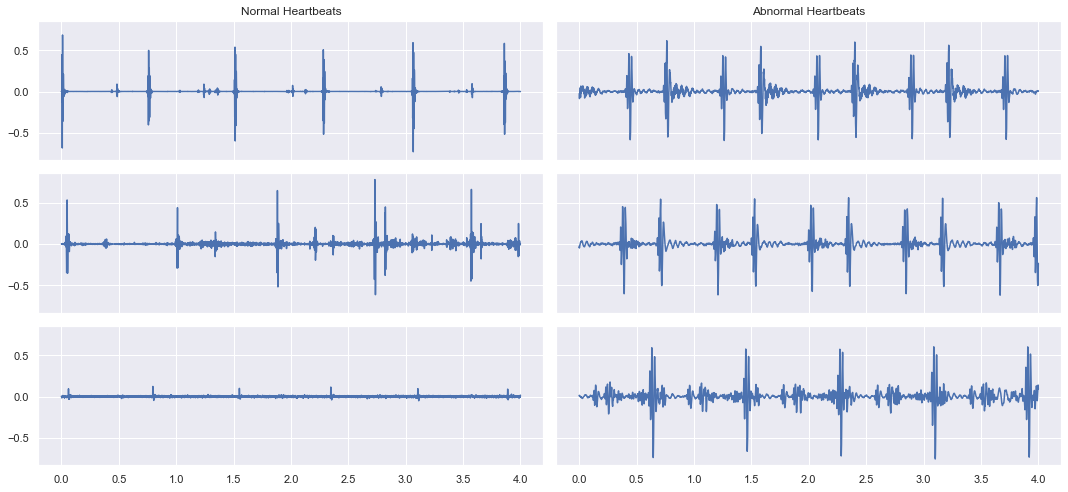

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7),
                        sharex=True,
                        sharey=True)

# calculate the time array
time = np.arange(len(normal)) / sfreq

# stack the normal & abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

# loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

As you can see there is a lot of variability in the raw data, let's see if we can average out some of that noise to notice a difference.

## Invariance in time

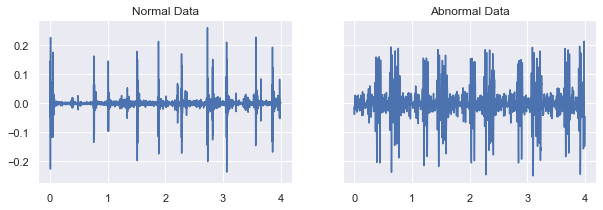

In [24]:
# average across the audio files of each dataframe
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3),
                               sharey=True)

ax1.plot(time, mean_normal)
ax2.plot(time, mean_abnormal)
ax1.set(title='Normal Data')
ax2.set(title='Abnormal Data')

plt.show()

There is a noticeable difference between the two, but it's still quite noisy. Let's see how we can dig into the data a bit further.

## Build a classification model

In [30]:
# load data
normal = pd.read_csv('./heart_normal.csv', index_col=0).T
abnormal = pd.read_csv('./heart_abnormal.csv', index_col=0).T
print(normal.shape)
print(abnormal.shape)

(29, 8820)
(31, 8820)


In [35]:
heartbeat = pd.concat([normal, abnormal], axis=0)
heartbeat['heartbeat'] = ['normal'] * normal.shape[0] + ['abnormal'] * abnormal.shape[0] # label

In [45]:
X = heartbeat.drop('heartbeat', axis=1)
y = heartbeat['heartbeat']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=18,
                                                    stratify=y,
                                                    random_state=42)

In [56]:
# fit and evaluate a linear svc
model = LinearSVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'test acc: {accuracy_score(y_test, y_pred): .1%}')

test acc:  55.6%


As expected, the predictions didn't do well. This is because the features used as inputs aren't very good at differentiating classes.

## Improving features for classification

* **The auditory envelope**
    * Smooth the data to calculate the envelope
    * Related to the total amount of audio energy present at each moment of time
    * **smoothing over time** - instead of averaging over all time, we can do a *local* average; removes short-term noise, while retaining general pattern
* **Auditory features: The Tempogram**
    * can summarize more complex temporal information with timeseries-specific functions
    * `librosa` is a great library for auditory and timeseries feature engineering
    * *tempogram* estimates the tempo of a sound over time
    * we can calculate summary statistics of tempo in the same way as the envelope

## Calculating the envelope of sound

In [57]:
audio_files = glob('./wav_files/*.wav')

In [72]:
audio, sfreq = lr.load(audio_files[0])  # load the first only
time = np.arange(len(audio)) / sfreq

# get only a 1-second interval
audio = pd.DataFrame(audio[:sfreq], index=time[:sfreq], columns=['beat'])

#rectify the audio signal
audio_rectified = audio.apply(lambda x: np.abs(x))

# smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(300)

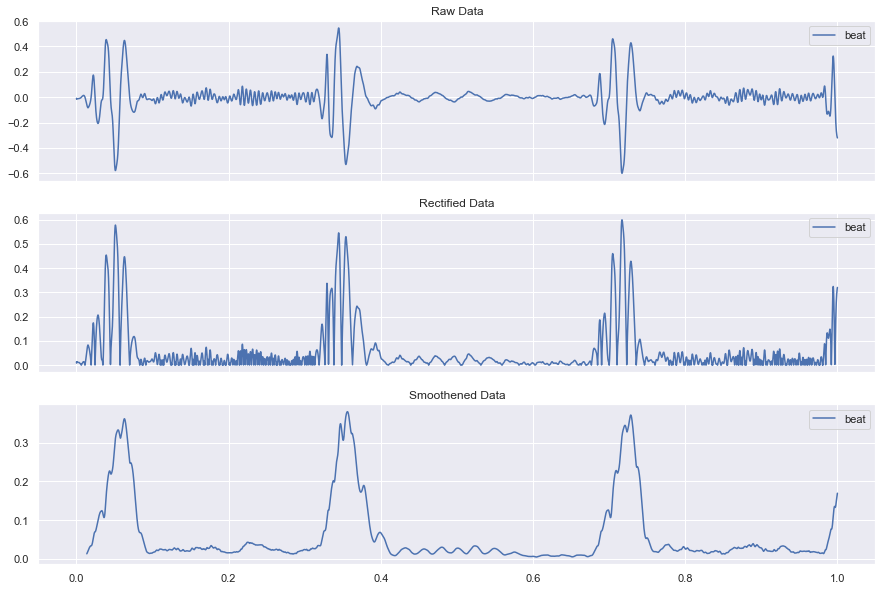

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10),
                                    sharex=True)

audio.plot(ax=ax1, title='Raw Data')
audio_rectified.plot(ax=ax2, title='Rectified Data')
audio_rectified_smooth.plot(ax=ax3, title='Smoothened Data')

plt.show()

## Calculating features from the envelope

In [93]:
# let's do it for all the heartbeat data
heartbeat_ = heartbeat.copy()

In [118]:
_X = heartbeat_.drop('heartbeat', axis=1).T
_X = _X.apply(lambda x: np.abs(x))
_X = _X.rolling(50, axis=0).mean()

In [140]:
# Calculate stats
means = np.mean(_X, axis=0)
stds = np.std(_X, axis=0)
maxs = np.max(_X, axis=0)

# Create X and y arrays
X = np.column_stack([means, stds, maxs])
y = heartbeat['heartbeat']
X, y = shuffle(X, y, random_state=42)

# fit a linear SVC and eval using cross_val_score
model = LinearSVC()
cv_results = cross_val_score(model, X, y, cv=5, n_jobs=-1)
print(f'acc: {np.mean(cv_results): .1%}')

acc:  71.7%


This model is both simpler (only 3 features) and more understandable (features are simple summary statistics of the data).

## Derivative features: The tempogram

Here, we'll be using `librosa` to compute some tempo and rhythm features for heartbeat data. Note that `librosa` functions tend to only operate on **numpy arrays**.

In [146]:
heartbeat_ = heartbeat.copy()
heartbeat_ = heartbeat_.drop('heartbeat', axis=1).T


In [158]:
heartbeat_.index = pd.to_numeric(heartbeat_.index)
sfreq = 2205

In [159]:
# calculate the tempo of the sounds
tempos = []
for col, i_audio in heartbeat_.items():
    tempos.append(lr.beat.tempo(i_audio.values,
                                sr=sfreq, 
                                hop_length=2**6,
                                aggregate=None))

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
C:\Users\loujo\anaconda3\envs\tf2-gpu\li

In [166]:
# convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# calculate stats
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

In [173]:
# create X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])
y = heartbeat['heartbeat']
X, y = shuffle(X, y, random_state=42)

# fit the model and eval
model = LinearSVC(random_state=42)
cv_results = cross_val_score(model, X, y, cv=5)
print(f'acc: {np.mean(cv_results): .1%}')

acc:  55.0%


C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to conver

Note that the predictive power may not have gone up because the dataset is quite small, but we now have a richer feature representation of the audio data.

## The spectrogram

* A *spectrogram* is a collection of windowed Fourier transforms over time
* Similar to how a rolling mean was calculated:
    1. Choose a window size and shape
    2. At a timepoint, calcualte the FFT for that window
    3. Slide the window over by one
    4. Aggregate the results
* Called a *Short-Time Fourier Transform (STFT)*

## Spectrograms of heartbeat audio

In [253]:
# take one heartbeat sound in heartbeat var
heartbeat1 = heartbeat_.iloc[:, 6].to_numpy()
sfreq=2205

In [254]:
# prepare the STFT
HOP_LENGTH = 2**4
spec = stft(heartbeat1, 
            hop_length=HOP_LENGTH,
            n_fft=2**7)

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\core\spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


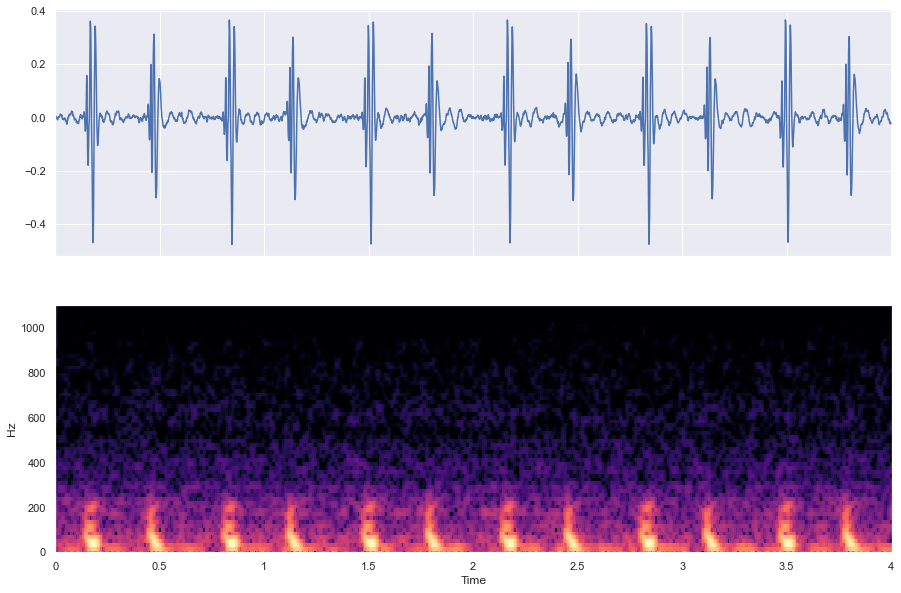

In [255]:
# convert into decibels
spec_db = amplitude_to_db(spec)

# compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(15, 10), 
                        sharex=True)

axs[0].plot(heartbeat_.index.values, heartbeat1)
specshow(spec_db,
         sr=sfreq,
         x_axis='time',
         y_axis='hz',
         hop_length=HOP_LENGTH,
         ax=axs[1])

plt.show()

## Engineering spectral features

In [221]:
# calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=np.abs(spec))[0]
centroids = lr.feature.spectral_centroid(S=np.abs(spec))[0]

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\librosa\core\spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


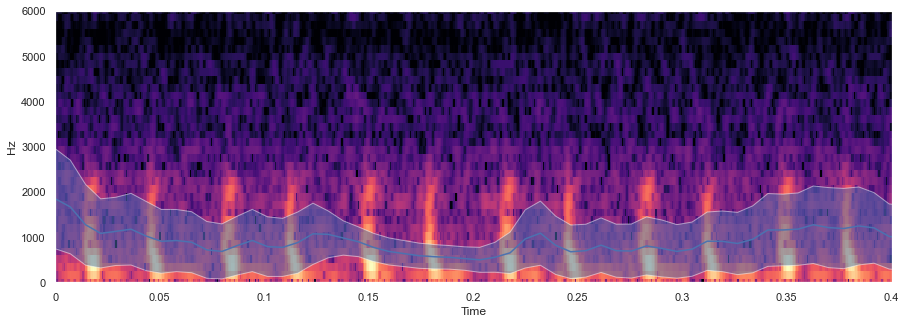

In [258]:
times_spec_idx = list(range(0, 8820, HOP_LENGTH))
times_spec = heartbeat_.index.values[times_spec_idx]

# convert spectrogram to decibels for visualization
spec_dc = amplitude_to_db(spec)

# display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(15, 5))

ax = specshow(spec_db,
              x_axis='time',
              y_axis='hz',
              hop_length=HOP_LENGTH)
ax.plot(times_spec, centroids)
ax.fill_between(times_spec, 
                centroids - bandwidths / 2,
                centroids + bandwidths / 2, 
                alpha=.5)
ax.set(ylim=[None, 6000])

plt.show()

As you can see, the spectral centroid and bandwidth characterize the spectral content in each sound over time. They give us a summary of the spectral content that we can use in a classifier.

## Combining many features in a classifier

In [276]:
# first lets calculate the spectrograms of all data
# in the heartbeat var
heartbeat_ = heartbeat.copy()
heartbeat_ = heartbeat_.drop('heartbeat', axis=1).T
heartbeat_.index = pd.to_numeric(heartbeat_.index)

spectrograms = []
sfreq = 2205
HOP_LENGTH = 2**4

for i_audio in range(heartbeat_.shape[1]):
    to_spec = heartbeat_.iloc[:, i_audio].to_numpy()
    
    spec = stft(to_spec, 
                hop_length=HOP_LENGTH,
                n_fft=2**7)
    
    spectrograms.append(np.abs(spec))

In [278]:
# loop through each spectrogram
bandwidths = []
centroids = []

for spec in spectrograms:
    # calculate mean spectral bandwidth
    this_mean_bw = np.mean(lr.feature.spectral_bandwidth(S=spec))
    # calculate mean spectral centroid
    this_mean_c = np.mean(lr.feature.spectral_centroid(S=spec))
    # append values
    bandwidths.append(this_mean_bw)
    centroids.append(this_mean_c)

In [301]:
# create X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean,
                     tempos_std, tempos_max, bandwidths, centroids])
y = heartbeat['heartbeat']
X, y = shuffle(X, y, random_state=42)

# fit and eval
model = LinearSVC(random_state=42, max_iter=500000)
cv_results = cross_val_score(model, X, y, cv=5)
print(f'acc: {np.mean(cv_results): .1%}')

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc:  71.7%


C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
